# M4 ETS Experiment


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use("ggplot")

c:\Users\robert.robison\.virtualenvs\nbo\lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
train = pd.read_csv("data/Yearly-train.csv", nrows=1000, index_col=0).dropna(axis=1, how="all")
test = pd.read_csv("data/Yearly-test.csv", nrows=1000, index_col=0).dropna(axis=1, how="all")
print(train.shape)
print(test.shape)

(1000, 84)
(1000, 6)


In [3]:
test.iloc[:20]

,V2,V3,V4,V5,V6,V7
V1,,,,,,
Y1,7290.2000,7392.6000,7527.6000,7594.8000,7720.7000,7823.2000
Y2,1598.0000,1366.0000,1288.0000,1148.0000,1139.0000,1062.0000
Y3,8440.0000,8660.0000,8780.0000,8830.0000,8990.0000,9230.0000
Y4,9540.0000,9790.0000,9940.0000,9940.0000,10110.0000,10400.0000
Y5,6840.0000,7420.0000,7570.0000,8010.0000,8240.0000,8730.0000
Y6,3751.7900,3854.5400,4003.4500,4229.1200,4502.0500,4741.7700
Y7,3169.2400,3188.3700,3231.0500,3318.3400,3430.4500,3540.6800
Y8,2357.8000,2357.1900,2359.2200,2346.7900,2349.5700,2352.8900
Y9,2234.8910,2235.6050,2234.6820,2232.1850,2217.8270,2206.2120


In [6]:
def calc_mase(train: pd.Series, y_test: np.ndarray, y_pred: np.ndarray) -> float:
    denom = train.diff().dropna().abs().mean()
    return np.abs(y_test - y_pred).mean() / denom


def calc_mase_df(
    train: pd.DataFrame, y_test: pd.DataFrame, y_pred: pd.Series
) -> pd.Series:
    denom = train.diff(axis=1).abs().mean(axis=1)
    abs_err = (y_test.T - y_pred).abs().mean(axis=0)
    return abs_err / denom

In [7]:
def eval_ets(
    train: pd.DataFrame, test: pd.DataFrame, alpha: float | None = None
) -> pd.DataFrame:
    row_list = []
    for i, row in tqdm(train.iterrows()):
        model = ExponentialSmoothing(
            row.dropna().to_numpy(), trend="add", damped_trend=True
        )
        res = model.fit(smoothing_level=alpha)
        preds = res.forecast(steps=6)
        mase = calc_mase(row.dropna(), test.loc[i].to_numpy(), preds)
        row = {
            "alpha": res.params["smoothing_level"],
            "beta": res.params["smoothing_trend"],
            "gamma": res.params["damping_trend"],
            "mase": mase,
        }
        row_list.append(row)
    return pd.DataFrame(row_list, index=train.index)

In [8]:
print("Using Auto-Alpha")
res = eval_ets(train.iloc[:1000], test)
display(res.describe())


Using Auto-Alpha


1000it [00:48, 20.44it/s]


,alpha,beta,gamma,mase
count,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,8.759459e-01,0.299923,0.961893,3.891302
std,2.241883e-01,0.355090,0.056509,4.704961
min,3.301441e-08,0.000000,0.800000,0.041624
25%,8.544972e-01,0.005472,0.970981,1.250912
50%,9.904733e-01,0.121490,0.990000,2.469507
75%,9.951070e-01,0.539698,0.990010,4.648262
max,1.000000e+00,1.000000,0.995000,42.089996


In [9]:
res["alpha_grp"] = "Between 0.01 and 0.99"
res.loc[res.alpha < 0.01, "alpha_grp"] = "Less than 0.01"
res.loc[res.alpha > 0.99, "alpha_grp"] = "Greater than 0.99"


In [12]:
print("Using mean")
mean_preds = train.mean(axis=1)
res3 = calc_mase_df(train, test, mean_preds)

print("Using naive")
naive_preds = train.ffill(axis=1).iloc[:, -1]
res4 = calc_mase_df(train, test, naive_preds)

all_res = res[["mase", "alpha_grp"]].copy().rename(columns={"mase": "Exponential Smoothing"})

for alpha in [0.5]:
    tmp = eval_ets(train, test, alpha=alpha)
    all_res[f"Exponential Smoothing,\nAlpha = {alpha:.1f}"] = tmp.mase.copy()
# all_res["Mean_mase"] = res3
all_res["Naive"] = res4
all_res.describe()


Using mean
Using naive


0it [00:00, ?it/s]

1000it [00:20, 48.20it/s]


,Exponential Smoothing,"Exponential Smoothing,\nAlpha = 0.5",Naive
count,1000.000000,1000.000000,1000.000000
mean,3.891302,3.422521,3.888122
std,4.704961,3.296569,3.794391
min,0.041624,0.087695,0.187805
25%,1.250912,1.314407,1.272633
50%,2.469507,2.356878,2.689712
75%,4.648262,4.296941,5.036621
max,42.089996,31.367741,27.819749


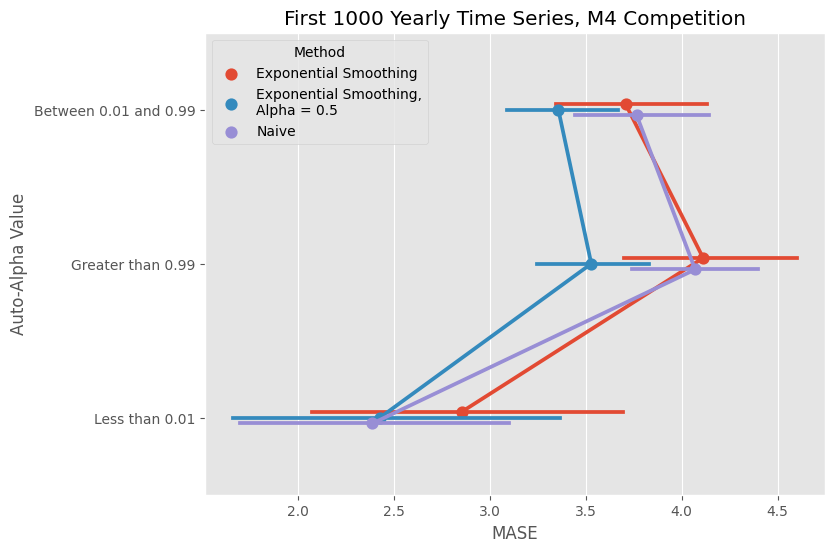

In [13]:
fig, ax=plt.subplots(figsize=(8, 6))
sns.pointplot(pd.melt(all_res, id_vars=["alpha_grp"], var_name="Method", value_name="MASE"), x="MASE", y="alpha_grp", ax=ax, hue="Method", dodge=True)
ax.set_title("First 1000 Yearly Time Series, M4 Competition")
ax.set_ylabel("Auto-Alpha Value")
plt.show()

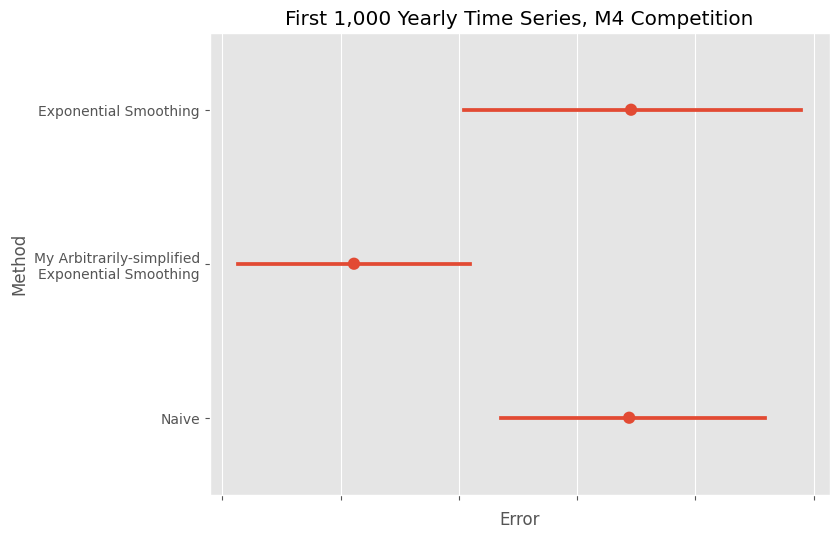

In [21]:
all_res = all_res.rename(
    columns={
        "Exponential Smoothing,\nAlpha = 0.5": (
            "My Arbitrarily-simplified\nExponential Smoothing"
        )
    }
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    pd.melt(all_res.drop(columns="alpha_grp"), var_name="Method", value_name="MASE"),
    x="MASE",
    y="Method",
    ax=ax,
    join=False,
)
ax.set_title("First 1,000 Yearly Time Series, M4 Competition")
ax.set_xlabel("Error")
ax.set_xticklabels([])
plt.show()